This is a small exercise to predict whether someone donated blood from a few features.

I did not spend much time analysing the data.

There were a few NaN values, and I tried 2 commonly-used techniques to deal with these:
- Dropping rows with NaNs. NaNs only make up about 5% of the data, so this is a viable strategy which doesn't remove too much useful data.
- Replacing NaNs with the median value. An alternative option would be using the mean, but the distributions of feature values have quite a long tail, so this could perform poorly.

For more accurate model metrics, one key improvement would be to separate training and test prior to the above. For dropping NaNs, it shouldn't matter too much since we're just randomly splitting the data (if this were e.g. time series data, it may be that some months have more NaNs than others, which would be something to take into consideration with regard to the data we're losing in dropping rows). For replacing NaNs, this is more important: the median calculation should only include the training set, not the test set, otherwise the performance of the test set is unreliable.

Of the two techniques, replacing NaNs performs better, with a precision of 52% and a recall of 34%. These results would often be considered fairly mediocre, although we don't have a baseline to compare it to. There are certainly a lot of things one could try to improve the performance.

One potential problem with the data is that it's only data for a single month.
- This is simply not a lot of data, limiting a model's ability to capture complex patterns in the data.
- The model could be heavily affected by seasonal effects (e.g. maybe blood donation differs between summer and winter).
- It does not consider the temporal order of data. It would not be particularly appropriate to use a resulting model to predict future donations, because this model would in effect be seeing into the future, by using training data for donations that wouldn't be available at prediction time. So we might expect the model to perform much worse in production.

  Using such a model may however be more appropriate if our use case is to e.g. send donation reminders to people who might not have donated recently (in case we're lacking the data about whether some people donated). In such a case, all data is in the past, so "seeing into the future" is less of a problem. Although the problem isn't fixed entirely, and it would still be better to have training and test where all the training examples occurred before all the test examples, to better match the difference between training and production data.

In [ ]:
import pandas as pd

df = pd.read_csv("data/blood-donation.csv")
df

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2.0,50.0,12500.0,98.0,1
1,0.0,13.0,3250.0,28.0,1
2,1.0,16.0,4000.0,35.0,1
3,2.0,20.0,5000.0,45.0,1
4,NaN,24.0,6000.0,77.0,0
...,...,...,...,...,...
743,23.0,2.0,500.0,38.0,0
744,21.0,2.0,500.0,52.0,0
745,23.0,3.0,750.0,62.0,0
746,39.0,1.0,250.0,39.0,0


In [8]:
df["whether he/she donated blood in March 2007"].value_counts()

0    570
1    178
Name: whether he/she donated blood in March 2007, dtype: int64

In [11]:
for c in df.columns:
    print(df[c].isna().value_counts())

False    706
True      42
Name: Recency (months), dtype: int64
False    715
True      33
Name: Frequency (times), dtype: int64
False    707
True      41
Name: Monetary (c.c. blood), dtype: int64
False    714
True      34
Name: Time (months), dtype: int64
False    748
Name: whether he/she donated blood in March 2007, dtype: int64


In [12]:
df2 = df.dropna()
df2["whether he/she donated blood in March 2007"].value_counts()

0    464
1    145
Name: whether he/she donated blood in March 2007, dtype: int64

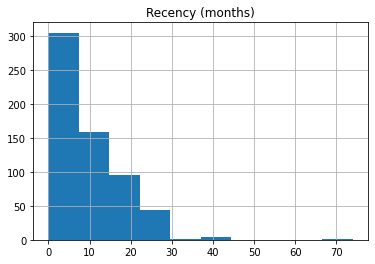

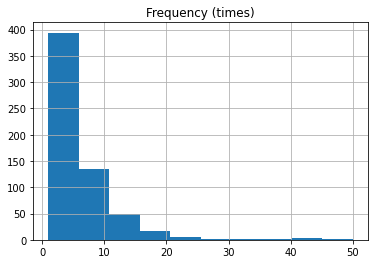

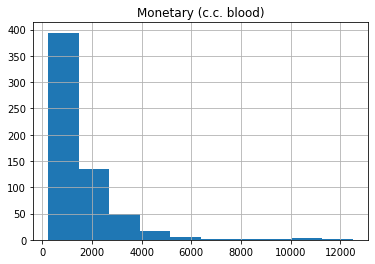

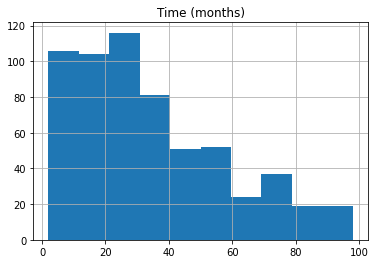

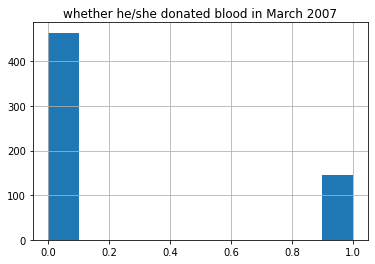

In [18]:
import matplotlib.pyplot as plt
for c in df.columns:
    ax = df2[c].hist()
    ax.set(title=c)
    plt.show()


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score

y = df2["whether he/she donated blood in March 2007"]
X = df2.drop("whether he/she donated blood in March 2007", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print(y_train.value_counts())
print(y_test.value_counts())

print(confusion_matrix(y_test, y_predict))

print("Precision:", precision_score(y_test, y_predict))
print("Recall:", recall_score(y_test, y_predict))


0    351
1    105
Name: whether he/she donated blood in March 2007, dtype: int64
0    113
1     40
Name: whether he/she donated blood in March 2007, dtype: int64
[[96 17]
 [28 12]]
Precision: 0.41379310344827586
Recall: 0.3


In [29]:
df3 = df.copy()
for c in ["Recency (months)", "Frequency (times)", "Monetary (c.c. blood)", "Time (months)"]:
    df3[c] = df3[c].fillna(df3[c].median())


,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2.0,50.0,12500.0,98.0,1
1,0.0,13.0,3250.0,28.0,1
2,1.0,16.0,4000.0,35.0,1
3,2.0,20.0,5000.0,45.0,1
4,7.0,24.0,6000.0,77.0,0
...,...,...,...,...,...
743,23.0,2.0,500.0,38.0,0
744,21.0,2.0,500.0,52.0,0
745,23.0,3.0,750.0,62.0,0
746,39.0,1.0,250.0,39.0,0


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score

y = df3["whether he/she donated blood in March 2007"]
X = df3.drop("whether he/she donated blood in March 2007", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print(y_train.value_counts())
print(y_test.value_counts())

print(confusion_matrix(y_test, y_predict))

print("Precision:", precision_score(y_test, y_predict))
print("Recall:", recall_score(y_test, y_predict))


0    433
1    128
Name: whether he/she donated blood in March 2007, dtype: int64
0    137
1     50
Name: whether he/she donated blood in March 2007, dtype: int64
[[121  16]
 [ 33  17]]
Precision: 0.5151515151515151
Recall: 0.34
